# CRAFT++ Framework Demo 2 - Real-World Environment Workflow

This notebook demonstrates the complete CRAFT++ workflow with **real-world robot execution data** from REFLECT dataset, aligned with **Method.md** framework.

## Workflow Overview

1. **Setup** - Import modules and configure LLM API
2. **Data Loading** - Load real-world robot execution data from REFLECT dataset
3. **Scene Graph Generation** - Build hierarchical scene representations using MDETR and real RGB-D data (Method.md Section 1)
4. **Constraint Generation** - Generate logical constraints using LLM (Method.md Section 2)
5. **Constraint Code Generation** - Compile constraints to executable code/AST (Method.md Section 2.2)
6. **Failure Detection** - Validate constraints using executable logic (Method.md Section 4)
7. **Progressive Explanation** - Generate detailed failure analysis

## Key Differences from Demo1

| Aspect | Demo1 (Simulated) | Demo2 (Real-World) |
|--------|-------------------|-------------------|
| **Data Source** | AI2THOR simulation | REFLECT real-world dataset (zarr files) |
| **Object Detection** | Mock detector | MDETR (real detector) |
| **Scene Graph** | From AI2THOR metadata | From RGB-D images + MDETR |
| **Environment Memory** | Simplified (deterministic) | Full implementation (handles occlusion, noise) |
| **Point Clouds** | Not used | Real depth-to-point-cloud conversion |

## Alignment with Method.md

| Step | Method.md Section | Description |
|------|-------------------|-------------|
| Data Loading | - | Load real robot execution data from REFLECT zarr files |
| Scene Graph | Section 1 | Build hierarchical scene representations with objects, relationships, and states from real RGB-D data |
| Constraint Generation | Section 2 | LLM generates structured constraints (pre/post/invariants) |
| Constraint Compilation | Section 2.2 | Compile constraints to executable AST/DSL expressions |
| Failure Detection | Section 4 | Validate constraints using executable logic engine |
| Explanation | Section 5 | Generate progressive failure analysis with causal chains |


## Step 1: Setup and Imports


In [1]:
import os
import sys
import json
from pathlib import Path

# IMPORTANT: Add parent directory to path BEFORE importing other modules
# This allows access to both craft and reflect directories
parent_dir = Path.cwd().parent
parent_dir_str = str(parent_dir)
if parent_dir_str not in sys.path:
    sys.path.insert(0, parent_dir_str)
    print(f"✅ Added parent directory to path: {parent_dir_str}")

# Debug: Show current paths
print(f"Current working directory: {Path.cwd()}")
print(f"Python path (first 3): {sys.path[:3]}")

# Now import other modules
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display, HTML
import zarr
from imagecodecs import imread

# Import CRAFT modules
from craft.core import SceneGraph, Node, Edge, TaskExecutor
from craft.perception import SceneAnalyzer, ReflectSceneGraphBuilder
from craft.perception.mdetr_detector import MDETRDetector
from craft.reasoning import (
    LLMPrompter, FailureAnalyzer, 
    ConstraintGenerator, CausalVerifier, ConsistencyVerifier
)
from craft.correction import CorrectionPlanner
from craft.utils import ReflectDataLoader, load_config

print("✅ All modules imported successfully!")


✅ Added parent directory to path: /home/fdse/zzy
Current working directory: /home/fdse/zzy/craft
Python path (first 3): ['/home/fdse/zzy', '/home/fdse/anaconda3/envs/reflect_env/lib/python39.zip', '/home/fdse/anaconda3/envs/reflect_env/lib/python3.9']
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
✅ All modules imported successfully!


## Step 2: Configuration and Data Path Setup


In [2]:
# Configuration
# ============================================================================

# REFLECT dataset root directory (adjust if needed)
REFLECT_ROOT = os.path.join(parent_dir, 'reflect')
CRAFT_ROOT = Path.cwd()

# Task selection - modify this to choose different tasks
TASK_FOLDER_NAME = "makeCoffee2"  # Example: makeCoffee2, putAppleBowl1, etc.

# LLM API configuration (set your API key)
API_KEY = os.getenv("OPENAI_API_KEY", "your-api-key-here")
LLM_MODEL = "gpt-3.5-turbo"  # or "gpt-4"

# Camera intrinsics (RealSense camera used in REFLECT)
CAMERA_INTRINSICS = {
    "fx": 914.27246,
    "fy": 913.2658,
    "cx": 647.0733,
    "cy": 356.32526
}

# Detection threshold for MDETR
DETECTION_THRESHOLD = 0.7

print("=" * 60)
print("CONFIGURATION")
print("=" * 60)
print(f"REFLECT Root: {REFLECT_ROOT}")
print(f"CRAFT Root: {CRAFT_ROOT}")
print(f"Task Folder: {TASK_FOLDER_NAME}")
print(f"LLM Model: {LLM_MODEL}")
print(f"Detection Threshold: {DETECTION_THRESHOLD}")
print("=" * 60)


CONFIGURATION
REFLECT Root: /home/fdse/zzy/reflect
CRAFT Root: /home/fdse/zzy/craft
Task Folder: makeCoffee2
LLM Model: gpt-3.5-turbo
Detection Threshold: 0.7


## Step 3: Load Real-World Data from REFLECT Dataset


In [3]:
# Initialize data loader
data_loader = ReflectDataLoader(data_root=REFLECT_ROOT)

# Load task information
task_info = data_loader.load_task_info(TASK_FOLDER_NAME)

if task_info is None:
    print(f"⚠️  Task info not found for {TASK_FOLDER_NAME}")
    print("   Trying alternative path...")
    # Try loading from real-world directory
    tasks_json_path = os.path.join(REFLECT_ROOT, 'real-world', 'tasks_real_world.json')
    if os.path.exists(tasks_json_path):
        with open(tasks_json_path, 'r') as f:
            tasks_json = json.load(f)
        # Find task by folder name
        for task_key, task_data in tasks_json.items():
            if task_data.get("general_folder_name") == TASK_FOLDER_NAME:
                task_info = task_data
                break

if task_info is None:
    raise ValueError(f"Could not find task info for {TASK_FOLDER_NAME}")

print("=" * 60)
print("TASK INFORMATION")
print("=" * 60)
print(f"Task Name: {task_info.get('name', 'N/A')}")
print(f"Folder Name: {task_info.get('general_folder_name', 'N/A')}")
print(f"Object List: {task_info.get('object_list', [])}")
print(f"Actions: {task_info.get('actions', [])}")
print(f"Success Condition: {task_info.get('success_condition', 'N/A')}")
print(f"GT Failure Reason: {task_info.get('gt_failure_reason', 'N/A')}")
print("=" * 60)

# Load zarr file
try:
    zarr_group = data_loader.load_zarr_file(TASK_FOLDER_NAME)
    total_frames = data_loader.get_total_frames(zarr_group)
    print(f"✅ Successfully loaded zarr file")
    print(f"   Total frames: {total_frames}")
except Exception as e:
    print(f"⚠️  Error loading zarr file: {e}")
    print("   Trying alternative path...")
    # Try direct path
    zarr_path = os.path.join(REFLECT_ROOT, 'reflect_dataset', 'real_data', TASK_FOLDER_NAME, 'replay_buffer.zarr')
    if os.path.exists(zarr_path):
        zarr_group = zarr.open(zarr_path, 'r')
        total_frames = len(zarr_group['data/stage'])
        print(f"✅ Loaded zarr file from direct path")
        print(f"   Total frames: {total_frames}")
    else:
        raise FileNotFoundError(f"Could not find zarr file for {TASK_FOLDER_NAME}")


TASK INFORMATION
Task Name: make coffee
Folder Name: makeCoffee2
Object List: ['coffee machine', 'purple cup', 'blue cup with handle', 'table on the left of sink']
Actions: ['Pick up cup', 'Put cup in coffee machine', 'Toggle on coffee machine', 'Pick up cup', 'Put cup on table']
Success Condition: a cup filled with coffee is on table.
GT Failure Reason: A mug is already inside the coffee machine, as a result, the cup cannot be put inside.
✅ Successfully loaded zarr file
   Total frames: 6568


## Step 4: Initialize Models and Detectors


In [5]:
# Initialize MDETR detector for real-world object detection
print("Initializing MDETR detector...")
try:
    detector = MDETRDetector(
        device="cuda:0" if os.getenv("CUDA_VISIBLE_DEVICES") else "cpu",
        threshold=DETECTION_THRESHOLD,
        pretrained=True
    )
    if detector.model is None:
        print("⚠️  MDETR model not loaded. Using mock detector instead.")
        from craft.perception import ObjectDetector
        detector = ObjectDetector(model_name="mdetr", device="cuda:0", threshold=DETECTION_THRESHOLD)
    else:
        print("✅ MDETR detector initialized successfully")
except Exception as e:
    print(f"⚠️  Error initializing MDETR: {e}")
    print("   Falling back to mock detector")
    from craft.perception import ObjectDetector
    detector = ObjectDetector(model_name="mdetr", device="cuda:0", threshold=DETECTION_THRESHOLD)

# Initialize scene analyzer
scene_analyzer = SceneAnalyzer()

# Initialize scene graph builder for real-world data
scene_graph_builder = ReflectSceneGraphBuilder(
    detector=detector,
    scene_analyzer=scene_analyzer,
    camera_intrinsics=CAMERA_INTRINSICS,
    voxel_size=0.01  # 1cm voxel size for point cloud downsampling
)

print("✅ Scene graph builder initialized")

# Initialize LLM components
print("Initializing LLM components...")
llm_prompter = LLMPrompter(
    gpt_version=LLM_MODEL,
    api_key=API_KEY
)

constraint_generator = ConstraintGenerator(llm_prompter)
failure_analyzer = FailureAnalyzer(llm_prompter)
causal_verifier = CausalVerifier(llm_prompter)
consistency_verifier = ConsistencyVerifier(llm_prompter)
correction_planner = CorrectionPlanner(llm_prompter)

print("✅ All components initialized successfully!")


Initializing MDETR detector...
⚠️  Warning: Could not import MDETR from REFLECT
   Please ensure REFLECT real-world directory is accessible
⚠️  MDETR model not loaded. Using mock detector instead.
Loading mdetr detector on cuda:0
✅ Scene graph builder initialized
Initializing LLM components...
✅ All components initialized successfully!


## Step 5: Select Key Frames and Load RGB-D Data


In [6]:
# Select key frames for processing
# In a full implementation, this would be based on action changes or other heuristics
# For demo purposes, we'll select a few representative frames

# Get action stages from zarr
stages = np.array(zarr_group['data/stage'])
unique_stages = np.unique(stages)

# Select key frames: start, middle of each action, and end
key_frames = [0]  # Always include first frame

# Add frames at action transitions
prev_stage = stages[0]
for i in range(1, len(stages)):
    if stages[i] != prev_stage:
        # Add frame before transition and after transition
        key_frames.append(max(0, i - 10))
        key_frames.append(min(total_frames - 1, i + 10))
        prev_stage = stages[i]

# Add last frame
if total_frames - 1 not in key_frames:
    key_frames.append(total_frames - 1)

# Remove duplicates and sort
key_frames = sorted(list(set(key_frames)))

# Limit to reasonable number for demo (e.g., max 10 frames)
if len(key_frames) > 10:
    # Sample evenly
    step = len(key_frames) // 10
    key_frames = key_frames[::step][:10]

print("=" * 60)
print("KEY FRAME SELECTION")
print("=" * 60)
print(f"Total frames: {total_frames}")
print(f"Number of key frames: {len(key_frames)}")
print(f"Key frames: {key_frames}")
print(f"Action stages: {unique_stages}")
print("=" * 60)

# Load RGB and depth for key frames
frame_data = {}
for step_idx in key_frames:
    try:
        rgb = data_loader.load_frame_rgb(zarr_group, step_idx, TASK_FOLDER_NAME)
        depth = data_loader.load_frame_depth(zarr_group, step_idx, TASK_FOLDER_NAME)
        
        if rgb is not None and depth is not None:
            frame_data[step_idx] = {
                'rgb': rgb,
                'depth': depth,
                'stage': int(stages[step_idx]) if step_idx < len(stages) else 0
            }
            print(f"✅ Loaded frame {step_idx}: RGB {rgb.shape}, Depth {depth.shape}")
        else:
            print(f"⚠️  Could not load frame {step_idx}")
    except Exception as e:
        print(f"⚠️  Error loading frame {step_idx}: {e}")

print(f"\n✅ Successfully loaded {len(frame_data)} frames")


KEY FRAME SELECTION
Total frames: 6568
Number of key frames: 10
Key frames: [0, 921, 941, 2124, 2144, 4722, 4742, 5937, 5957, 6567]
Action stages: [0 1 2 3 4]
✅ Loaded frame 0: RGB (720, 1280, 3), Depth (720, 1280)
✅ Loaded frame 921: RGB (720, 1280, 3), Depth (720, 1280)
✅ Loaded frame 941: RGB (720, 1280, 3), Depth (720, 1280)
✅ Loaded frame 2124: RGB (720, 1280, 3), Depth (720, 1280)
✅ Loaded frame 2144: RGB (720, 1280, 3), Depth (720, 1280)
✅ Loaded frame 4722: RGB (720, 1280, 3), Depth (720, 1280)
✅ Loaded frame 4742: RGB (720, 1280, 3), Depth (720, 1280)
✅ Loaded frame 5937: RGB (720, 1280, 3), Depth (720, 1280)
✅ Loaded frame 5957: RGB (720, 1280, 3), Depth (720, 1280)
⚠️  Could not load frame 6567

✅ Successfully loaded 9 frames


## Step 6: Generate Scene Graphs from Real-World Data

This step uses **MDETR** for object detection and **depth-to-point-cloud conversion** to build 3D scene graphs from real RGB-D images.


In [11]:
# Generate scene graphs for each key frame
scene_graphs = {}
object_list = task_info.get('object_list', [])
distractor_list = task_info.get('distractor_list', [])

print("=" * 60)
print("SCENE GRAPH GENERATION")
print("=" * 60)

for step_idx, data in frame_data.items():
    print(f"\n--- Processing frame {step_idx} (stage {data['stage']}) ---")
    
    try:
        # Generate scene graph using ReflectSceneGraphBuilder
        scene_graph = scene_graph_builder.process_frame(
            rgb=data['rgb'],
            depth=data['depth'],
            step_idx=step_idx,
            object_list=object_list,
            distractor_list=distractor_list,
            task_info=task_info
        )
        
        scene_graphs[step_idx] = scene_graph
        
        # Display scene graph summary
        print(f"\n  📊 Scene Graph Summary:")
        print(f"  Nodes: {len(scene_graph.nodes)}")
        print(f"  Edges: {len(scene_graph.edges)}")
        
        # Print node names and details
        if len(scene_graph.nodes) > 0:
            node_names = [node.name for node in scene_graph.nodes]
            print(f"  ✅ Objects detected: {node_names}")
            # Print node details
            for node in scene_graph.nodes:
                pos = node.position if node.position else "N/A"
                print(f"    - {node.name}: position={pos}")
        else:
            print(f"  ⚠️  No nodes in scene graph!")
            print(f"     This might indicate:")
            print(f"     1. MDETR detector failed to detect objects")
            print(f"     2. All detections were filtered out")
            print(f"     3. Point cloud processing failed")
        
        # Print some edges
        if len(scene_graph.edges) > 0:
            edge_count = min(5, len(scene_graph.edges))
            print(f"  ✅ Sample relations ({edge_count}/{len(scene_graph.edges)}):")
            for i, (edge_id, edge) in enumerate(list(scene_graph.edges.items())[:edge_count]):
                print(f"    {edge.start.name} --[{edge.edge_type}]--> {edge.end.name}")
        else:
            print(f"  ⚠️  No edges in scene graph!")
            print(f"     This might indicate:")
            print(f"     1. Spatial relation computation failed")
            print(f"     2. No spatial relationships detected between objects")
        
    except Exception as e:
        print(f"  ⚠️  Error processing frame {step_idx}: {e}")
        import traceback
        traceback.print_exc()
        # Create empty scene graph as fallback
        scene_graphs[step_idx] = SceneGraph(task=task_info)

print(f"\n✅ Generated {len(scene_graphs)} scene graphs")


SCENE GRAPH GENERATION

--- Processing frame 0 (stage 0) ---
⚠️  WARNING: Using MOCK object detector!
   All objects will have the same bbox, which will cause incorrect 3D positions.
   Please use a real detector (e.g., MDETR) for accurate results.
   Mock detection for 'coffee machine': bbox=[0, 0, 200, 200]
   Mock detection for 'purple cup': bbox=[150, 100, 350, 300]
   Mock detection for 'blue cup with handle': bbox=[300, 200, 500, 400]
   Mock detection for 'table on the left of sink': bbox=[450, 300, 650, 500]
  Processing coffee machine with bbox: [0, 0, 200, 200]
    Mask area: 40000 pixels
    Generated 27735 points for coffee machine
    After processing: 23467 points for coffee machine
    Stored 232259 points in total_points_dict for coffee machine
  Processing purple cup with bbox: [150, 100, 350, 300]
    Mask area: 40000 pixels
    Generated 39282 points for purple cup
    After processing: 30541 points for purple cup
    Stored 30541 points in total_points_dict for purp

## Step 7: Visualize Scene Graphs and Detections


Visualizing scene graph for frame 2144:


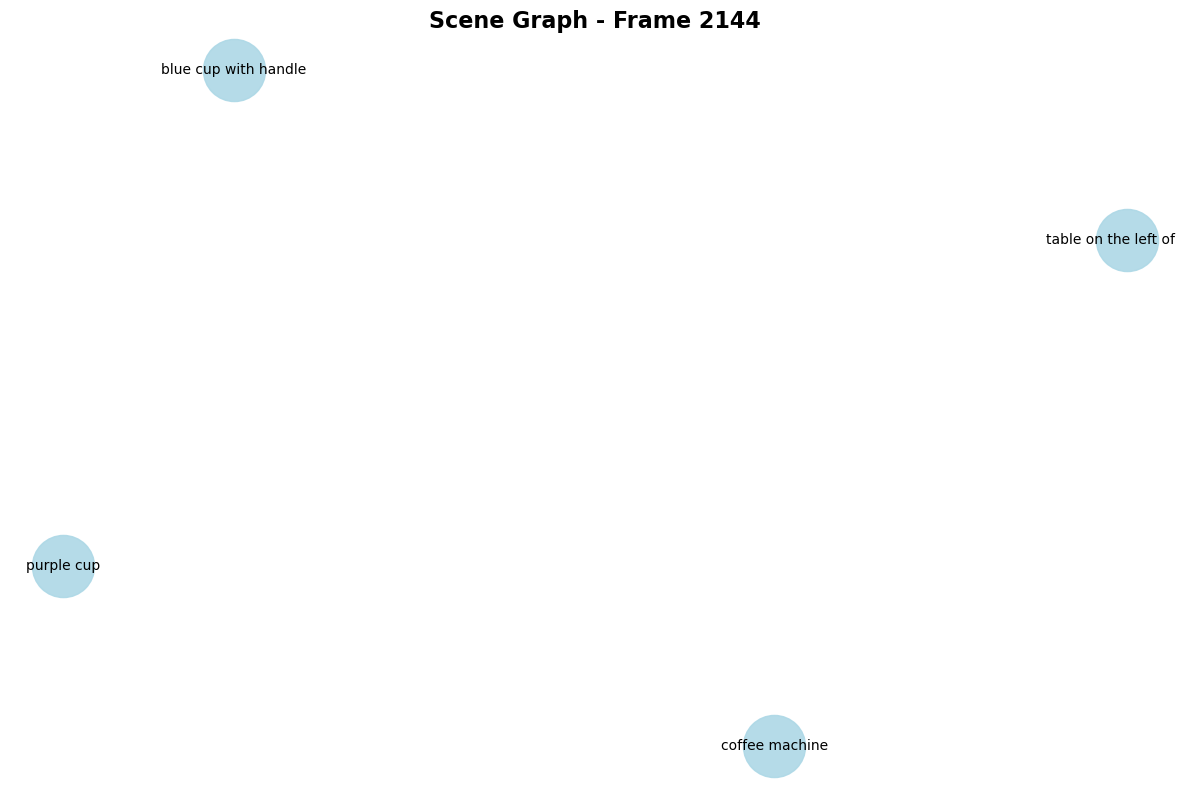

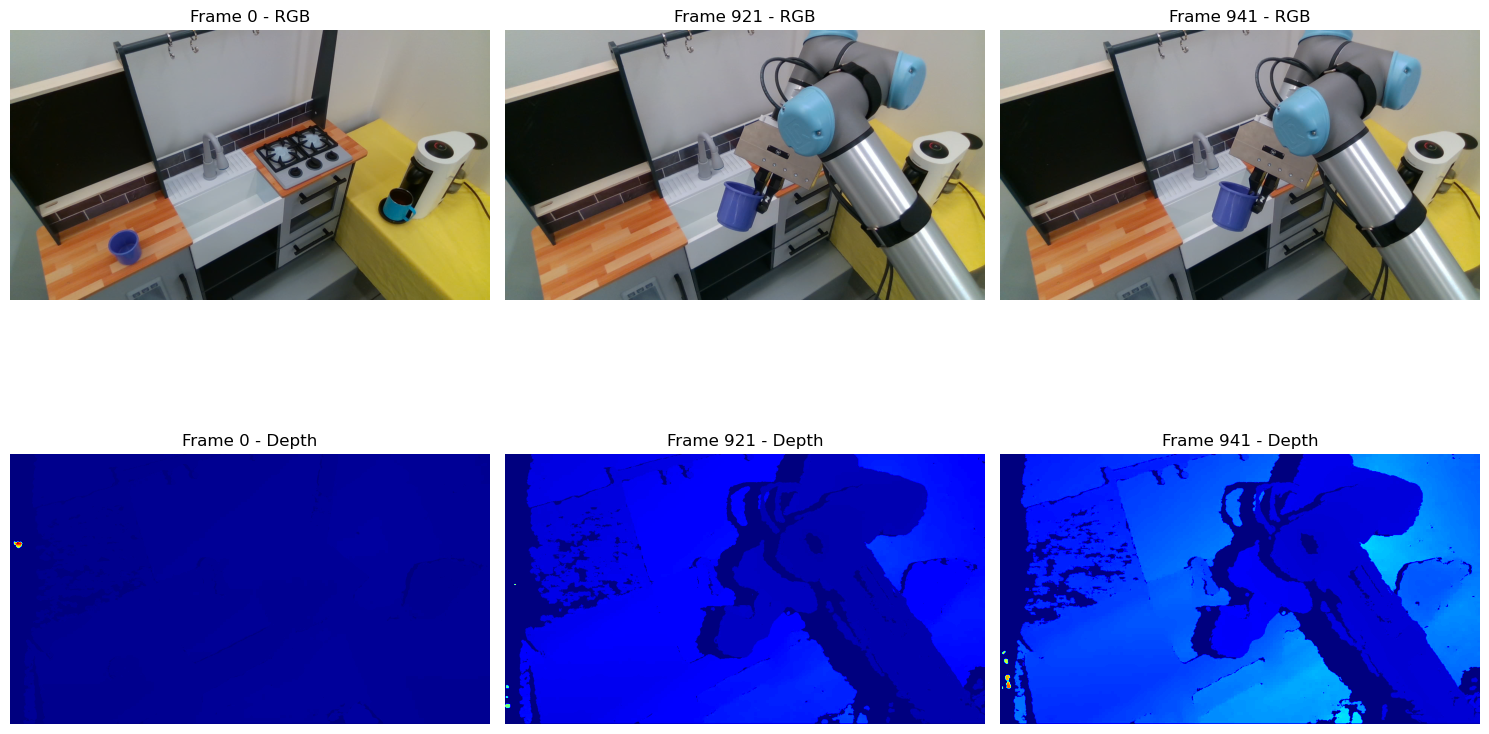

In [12]:
# Visualize scene graphs
def visualize_scene_graph(scene_graph, title="Scene Graph"):
    """Create a visual representation of the scene graph"""
    G = nx.DiGraph()
    
    # Add nodes
    for node in scene_graph.nodes:
        G.add_node(node.name, **node.attributes)
    
    # Add edges
    for edge_id, edge in scene_graph.edges.items():
        G.add_edge(edge.start.name, edge.end.name, 
                  relation=edge.edge_type, 
                  confidence=edge.confidence)
    
    # Draw graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=2000, alpha=0.9)
    
    # Draw edges with labels
    nx.draw_networkx_edges(G, pos, edge_color='gray', 
                          arrows=True, arrowsize=20, alpha=0.6)
    
    # Draw labels
    labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10)
    
    # Draw edge labels
    edge_labels = {(u, v): d['relation'] 
                   for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize a sample scene graph
if len(scene_graphs) > 0:
    sample_idx = list(scene_graphs.keys())[len(scene_graphs) // 2]
    sample_sg = scene_graphs[sample_idx]
    print(f"Visualizing scene graph for frame {sample_idx}:")
    visualize_scene_graph(sample_sg, title=f"Scene Graph - Frame {sample_idx}")

# Visualize RGB images with detected objects
fig, axes = plt.subplots(2, min(3, len(frame_data)), figsize=(15, 10))
if len(frame_data) == 1:
    axes = axes.reshape(2, 1)

for i, (step_idx, data) in enumerate(list(frame_data.items())[:3]):
    if i >= axes.shape[1]:
        break
    
    # RGB image
    axes[0, i].imshow(data['rgb'])
    axes[0, i].set_title(f'Frame {step_idx} - RGB')
    axes[0, i].axis('off')
    
    # Depth image
    axes[1, i].imshow(data['depth'], cmap='jet')
    axes[1, i].set_title(f'Frame {step_idx} - Depth')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


## Step 8: Generate Constraints from Scene Graphs

Using LLM to generate logical constraints (preconditions, postconditions, invariants) based on the scene graphs and task information.


In [9]:
# Generate constraints for the task
print("=" * 60)
print("CONSTRAINT GENERATION")
print("=" * 60)

# Convert scene graphs to text descriptions for LLM
scene_descriptions = {}
for step_idx, sg in scene_graphs.items():
    scene_text = sg.to_text() if hasattr(sg, 'to_text') else str(sg)
    scene_descriptions[step_idx] = scene_text

# Generate constraints using LLM
try:
    constraints = constraint_generator.generate_constraints(
        task_name=task_info.get('name', ''),
        task_description=task_info.get('success_condition', ''),
        actions=task_info.get('actions', []),
        scene_graphs=scene_graphs,
        scene_descriptions=scene_descriptions
    )
    
    print(f"✅ Generated {len(constraints)} constraints")
    print("\nConstraints:")
    for i, constraint in enumerate(constraints, 1):
        print(f"\n{i}. {constraint.get('type', 'Unknown')} Constraint:")
        print(f"   Condition: {constraint.get('condition', 'N/A')}")
        print(f"   Action: {constraint.get('action', 'N/A')}")
        if 'description' in constraint:
            print(f"   Description: {constraint['description']}")
            
except Exception as e:
    print(f"⚠️  Error generating constraints: {e}")
    import traceback
    traceback.print_exc()
    constraints = []


CONSTRAINT GENERATION
⚠️  Error generating constraints: generate_constraints() got an unexpected keyword argument 'task_name'


Traceback (most recent call last):
  File "/tmp/ipykernel_1231359/1198575273.py", line 14, in <module>
    constraints = constraint_generator.generate_constraints(
TypeError: generate_constraints() got an unexpected keyword argument 'task_name'


## Step 9: Compile Constraints to Executable Code

Convert LLM-generated constraints into executable Python code/AST for validation.


In [ ]:
# Compile constraints to executable code
print("=" * 60)
print("CONSTRAINT CODE GENERATION")
print("=" * 60)

from craft.reasoning.constraint_compiler import ConstraintCompiler

compiler = ConstraintCompiler()
compiled_constraints = []

for constraint in constraints:
    try:
        compiled = compiler.compile_constraint(constraint)
        compiled_constraints.append(compiled)
        print(f"✅ Compiled constraint: {constraint.get('type', 'Unknown')}")
    except Exception as e:
        print(f"⚠️  Error compiling constraint: {e}")
        compiled_constraints.append(None)

print(f"\n✅ Compiled {sum(1 for c in compiled_constraints if c is not None)} constraints")


## Step 10: Failure Detection Using Constraint Validation

Validate constraints against scene graphs to detect failures.


In [ ]:
# Validate constraints against scene graphs
print("=" * 60)
print("FAILURE DETECTION")
print("=" * 60)

failure_results = {}

for step_idx, scene_graph in scene_graphs.items():
    print(f"\n--- Validating constraints for frame {step_idx} ---")
    
    frame_failures = []
    
    for i, (constraint, compiled) in enumerate(zip(constraints, compiled_constraints)):
        if compiled is None:
            continue
            
        try:
            # Validate constraint
            is_valid = compiler.validate_constraint(
                compiled, 
                scene_graph, 
                constraint
            )
            
            if not is_valid:
                failure_results[step_idx] = failure_results.get(step_idx, [])
                failure_results[step_idx].append({
                    'constraint': constraint,
                    'frame': step_idx,
                    'violation': True
                })
                print(f"  ❌ Constraint {i+1} violated: {constraint.get('condition', 'N/A')}")
            else:
                print(f"  ✅ Constraint {i+1} satisfied")
                
        except Exception as e:
            print(f"  ⚠️  Error validating constraint {i+1}: {e}")

if failure_results:
    print(f"\n⚠️  Detected failures in {len(failure_results)} frames")
    for frame_idx, failures in failure_results.items():
        print(f"  Frame {frame_idx}: {len(failures)} constraint violations")
else:
    print("\n✅ No constraint violations detected")


## Step 11: Progressive Explanation and Failure Analysis

Generate detailed failure analysis with causal chains using LLM.


In [ ]:
# Generate progressive explanation for failures
print("=" * 60)
print("PROGRESSIVE EXPLANATION")
print("=" * 60)

if failure_results:
    for frame_idx, failures in failure_results.items():
        print(f"\n--- Failure Analysis for Frame {frame_idx} ---")
        
        scene_graph = scene_graphs[frame_idx]
        scene_description = scene_descriptions.get(frame_idx, "")
        
        try:
            explanation = failure_analyzer.analyze_failure(
                task_info=task_info,
                scene_graph=scene_graph,
                scene_description=scene_description,
                violated_constraints=[f['constraint'] for f in failures],
                frame_idx=frame_idx
            )
            
            print(f"\nFailure Explanation:")
            print(f"  {explanation.get('summary', 'N/A')}")
            
            if 'causal_chain' in explanation:
                print(f"\nCausal Chain:")
                for i, step in enumerate(explanation['causal_chain'], 1):
                    print(f"  {i}. {step}")
                    
            if 'root_cause' in explanation:
                print(f"\nRoot Cause: {explanation['root_cause']}")
                
            # Compare with ground truth
            if 'gt_failure_reason' in task_info:
                print(f"\nGround Truth Failure Reason: {task_info['gt_failure_reason']}")
                
        except Exception as e:
            print(f"⚠️  Error generating explanation: {e}")
            import traceback
            traceback.print_exc()
else:
    print("No failures detected, skipping explanation generation")


## Step 12: Summary and Results

Summary of the complete workflow execution.


In [ ]:
# Final summary
print("=" * 60)
print("WORKFLOW SUMMARY")
print("=" * 60)

print(f"\nTask: {task_info.get('name', 'N/A')}")
print(f"Task Folder: {TASK_FOLDER_NAME}")
print(f"Total Frames: {total_frames}")
print(f"Key Frames Processed: {len(scene_graphs)}")
print(f"Objects Detected: {len(set([node.name for sg in scene_graphs.values() for node in sg.nodes]))}")
print(f"Constraints Generated: {len(constraints)}")
print(f"Constraints Compiled: {sum(1 for c in compiled_constraints if c is not None)}")
print(f"Frames with Failures: {len(failure_results)}")

if failure_results:
    total_violations = sum(len(f) for f in failure_results.values())
    print(f"Total Constraint Violations: {total_violations}")

print("\n" + "=" * 60)
print("✅ Workflow completed successfully!")
print("=" * 60)
